SECTION 1: IMPORTS AND DEPENDENCIES

In [2]:
# Import libraries for data processing, visualization, forecasting, and dashboard creation
# Context: Analyzing Uganda's 2025/2026 National Budget (UGX 72T) with focus on revenue/expenditure trends
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
import requests
from datetime import datetime
import re
import os
import webbrowser
from IPython.display import display, HTML

# Set pandas options to avoid warnings
pd.set_option('future.no_silent_downcasting', True)

SECTION 2: DATA COLLECTION AND CLEANING

In [3]:

def fetch_worldbank_data(indicator, country='UGA'):
    """Fetch macroeconomic data from World Bank API."""
    try:
        url = f"http://api.worldbank.org/v2/country/{country}/indicator/{indicator}?format=json&per_page=100"
        response = requests.get(url, timeout=10)
        data = response.json()[1]
        if not data:
            raise ValueError(f"No data returned for indicator {indicator}")
        return pd.DataFrame({
            'Date': [datetime.strptime(d['date'], '%Y') for d in data],
            'Value': [d['value'] for d in data],
            'Indicator': indicator
        })
    except Exception as e:
        print(f"Error fetching World Bank data for {indicator}: {str(e)}")
        return pd.DataFrame()

def fetch_macro_data():
    """Fetch inflation and GDP growth from World Bank API."""
    indicators = {
        'FP.CPI.TOTL.ZG': 'Inflation',
        'NY.GDP.MKTP.KD.ZG': 'GDP Growth'
    }
    macro_data = pd.DataFrame()
    for indicator, name in indicators.items():
        df = fetch_worldbank_data(indicator)
        if not df.empty:
            df['Indicator'] = name
            macro_data = pd.concat([macro_data, df])
    if macro_data.empty:
        print("Warning: No macro data fetched. Using dummy data.")
        dates = pd.date_range(start='2010-01-01', end='2025-01-01', freq='YS')
        macro_data = pd.concat([
            pd.DataFrame({
                'Date': dates,
                'Value': np.random.uniform(1, 5, len(dates)),
                'Indicator': 'GDP Growth'
            }),
            pd.DataFrame({
                'Date': dates,
                'Value': np.random.uniform(1, 10, len(dates)),
                'Indicator': 'Inflation'
            })
        ])
    # Convert Date to fiscal year format (YYYY-YYYY)
    macro_data['Year'] = macro_data['Date'].apply(lambda x: f"{x.year}-{x.year+1}")
    return macro_data.pivot(index='Year', columns='Indicator', values='Value')

def clean_revenue_data(data):
    """Clean and standardize revenue data with consistent fiscal year formatting."""
    df = data.copy()
    df = df.dropna(how='all').loc[:, ~df.columns.str.contains('^Unnamed')]
    df['TAX HEADS'] = df['TAX HEADS'].ffill()
    df['Tax Category'] = df['Tax Category'].ffill()
    df = df.dropna(subset=df.columns[2:], how='all')
    
    for col in df.columns[2:]:
        df[col] = (
            df[col]
            .replace(['-', ''], np.nan)
            .astype(str)
            .str.replace(',', '')
            .astype(float)
            * 1e9  # Convert from billions to base units
        )
    
    df_clean = df.melt(
        id_vars=['TAX HEADS', 'Tax Category'],
        var_name='Fiscal Year',
        value_name='Amount'
    )
    
    def standardize_fiscal_year(year_str):
        """Convert various fiscal year formats to YYYY-YYYY format."""
        year_str = str(year_str).upper().replace('FY', '').strip()
        if re.match(r'^\d{4}-\d{4}$', year_str):
            return year_str
        if re.match(r'^\d{4}/\d{4}$', year_str):
            return year_str.replace('/', '-')
        if re.match(r'^\d{4}/\d{2}$', year_str):
            parts = year_str.split('/')
            return f"{parts[0]}-20{parts[1]}"
        if re.match(r'^\d{4}$', year_str):
            return f"{year_str}-{int(year_str)+1}"
        year_str = re.sub(r'[^\d]', '-', year_str)
        parts = [p for p in year_str.split('-') if p]
        if len(parts) == 2:
            part1, part2 = parts
            part1 = part1.zfill(4)
            part2 = f"20{part2}" if len(part2) == 2 else part2.zfill(4)
            return f"{part1}-{part2}"
        return year_str
    
    df_clean['Fiscal Year'] = df_clean['Fiscal Year'].apply(standardize_fiscal_year)
    fiscal_years = sorted(df_clean['Fiscal Year'].unique(), key=lambda x: int(x.split('-')[0]))
    year_cat = CategoricalDtype(categories=fiscal_years, ordered=True)
    df_clean['Fiscal Year'] = df_clean['Fiscal Year'].astype(year_cat)
    df_clean['Start Year'] = df_clean['Fiscal Year'].str.split('-').str[0].astype(int)
    df_clean['End Year'] = df_clean['Fiscal Year'].str.split('-').str[1].astype(int)
    
    df_clean[['Category Level 1', 'Category Level 2']] = (
        df_clean['Tax Category'].str.split(' ', n=1, expand=True)
    )
    
    text_cols = ['Category Level 1', 'Category Level 2', 'TAX HEADS', 'Tax Category']
    for col in text_cols:
        df_clean[col] = (
            df_clean[col]
            .str.title()
            .str.replace(r'\s+', ' ', regex=True)
            .str.strip()
        )
    
    df_clean = df_clean.dropna(subset=['Amount']).rename(columns={'Fiscal Year': 'Year'})
    return df_clean

def clean_expense_data(data):
    """Clean and standardize expense data."""
    df = data.copy()
    df = df.dropna(how='all').loc[:, ~df.columns.str.contains('^Unnamed')]
    
    if 'Amount' in df.columns:
        df['Amount'] = (
            df['Amount']
            .replace(['-', ''], np.nan)
            .astype(str)
            .str.replace(',', '')
            .astype(float)
        )
    
    if 'Year' in df.columns:
        fiscal_years = sorted(df['Year'].unique(), key=lambda x: int(x.split('-')[0]))
        year_cat = CategoricalDtype(categories=fiscal_years, ordered=True)
        df['Year'] = df['Year'].astype(str).str.strip().astype(year_cat)
        df['Start Year'] = df['Year'].str.split('-').str[0].astype(int)
        df['End Year'] = df['Year'].str.split('-').str[1].astype(int)
    
    text_cols = ['Category', 'SourceOfFunding', 'SectorName', 'VoteName',
                 'ProgrammeName', 'SubProgramName', 'KeyOutputDescription',
                 'Description', 'ClassificationName', 'OutputClassName']
    for col in text_cols:
        if col in df.columns:
            df[col] = (
                df[col]
                .astype(str)
                .str.title()
                .str.replace(r'\s+', ' ', regex=True)
                .str.strip()
            )
    
    code_cols = ['SectorCode', 'VoteCode', 'ProgramCode', 'SubProgramCode',
                 'KeyOutputCode', 'ItemCode', 'ClassificationCode', 'OutputClassCode']
    for col in code_cols:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip()
    
    if 'Quarter' in df.columns:
        df['Quarter'] = (
            df['Quarter']
            .astype(str)
            .str.upper()
            .str.replace('QUARTER', 'Q')
            .str.replace('[^Q0-9]', '', regex=True)
        )
        q_cat = CategoricalDtype(categories=['Q1', 'Q2', 'Q3', 'Q4'], ordered=True)
        df['Quarter'] = df['Quarter'].astype(q_cat)
    
    df = df.dropna(subset=['Amount'])
    return df

def integrate_budget_data(revenue_path, expense_path):
    """Integrate cleaned revenue and expense datasets with macroeconomic data."""
    if not (os.path.exists(revenue_path) and os.path.exists(expense_path)):
        raise FileNotFoundError("Revenue or expense file not found")
    
    rev = clean_revenue_data(pd.read_excel(revenue_path, sheet_name="Data"))
    exp = clean_expense_data(pd.read_excel(expense_path, sheet_name="Data"))
    macro = fetch_macro_data()
    
    all_years = sorted(
        set(rev['Year'].unique()).union(set(exp['Year'].unique())),
        key=lambda x: int(x.split('-')[0])
    )
    year_cat = CategoricalDtype(categories=all_years, ordered=True)
    
    rev['Year'] = rev['Year'].astype(year_cat)
    exp['Year'] = exp['Year'].astype(year_cat)
    
    rev_agg = rev.groupby('Year', observed=True)['Amount'].sum().reset_index()
    rev_agg['Type'] = 'Revenue'
    rev_agg['Amount'] = rev_agg['Amount'] / 1e12  # Convert to trillions
    
    exp_agg = exp.groupby('Year', observed=True)['Amount'].sum().reset_index()
    exp_agg['Type'] = 'Expenditure'
    exp_agg['Amount'] = exp_agg['Amount'] / 1e12  # Convert to trillions
    
    budget = pd.concat([rev_agg, exp_agg])
    budget['Year'] = budget['Year'].astype(year_cat)
    budget = budget.sort_values('Year')
    
    pivot_budget = budget.pivot(index='Year', columns='Type', values='Amount')
    pivot_budget['Deficit'] = pivot_budget['Expenditure'] - pivot_budget['Revenue']
    pivot_budget['Deficit %'] = (pivot_budget['Deficit'] / pivot_budget['Revenue']) * 100
    
    # Fix: Ensure macro Year is categorical and matches pivot_budget Year
    macro = macro.reset_index()
    macro['Year'] = macro['Year'].astype(str)
    pivot_budget = pivot_budget.reset_index()
    pivot_budget['Year'] = pivot_budget['Year'].astype(str)  # Convert category to string for merge
    pivot_budget = pivot_budget.merge(
        macro, on='Year', how='left'
    )
    pivot_budget['Year'] = pivot_budget['Year'].astype(year_cat)  # Restore categorical type
    pivot_budget = pivot_budget.set_index('Year')
    
    return budget, pivot_budget, rev, exp

SECTION 3: EXPLORATORY DATA ANALYSIS

In [4]:

def detect_anomalies(data, column, threshold=2):
    """Detect anomalies in a time series using z-scores."""
    series = data[column].dropna()
    z_scores = (series - series.mean()) / series.std()
    anomalies = series[abs(z_scores) > threshold]
    return anomalies

def plot_eda(budget, pivot_budget, rev, exp):
    """Perform EDA with visualizations."""
    # Revenue vs. Expenditure Trends
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=budget, x='Year', y='Amount', hue='Type', style='Type', markers=True)
    plt.title('Uganda Budget Trends (Revenue vs. Expenditure)', fontsize=16)
    plt.xlabel('Fiscal Year')
    plt.ylabel('Amount (UGX Trillions)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('budget_trends.png')
    plt.show()
    
    # Deficit Trends
    plt.figure(figsize=(14, 7))
    sns.barplot(x=pivot_budget.index, y=pivot_budget['Deficit'])
    plt.title('Fiscal Deficit Over Time', fontsize=16)
    plt.xlabel('Fiscal Year')
    plt.ylabel('Deficit (UGX Trillions)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('deficit_trends.png')
    plt.show()
    
    # Correlation with Macro Indicators
    if 'Inflation' in pivot_budget.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=pivot_budget, x='Inflation', y='Deficit %')
        plt.title('Deficit % vs. Inflation', fontsize=16)
        plt.xlabel('Inflation (%)')
        plt.ylabel('Deficit (% of Revenue)')
        plt.tight_layout()
        plt.savefig('deficit_inflation.png')
        plt.show()
    
    # Anomalies
    rev_anomalies = detect_anomalies(pivot_budget, 'Revenue')
    exp_anomalies = detect_anomalies(pivot_budget, 'Expenditure')
    print("\nRevenue Anomalies:", rev_anomalies)
    print("Expenditure Anomalies:", exp_anomalies)

SECTION 4: PREDICTIVE MODELING

In [5]:

def forecast_budget(pivot_df, years=3):
    """Forecast revenue and expenditure using Prophet."""
    df = pivot_df[['Revenue', 'Expenditure']].reset_index().melt(
        id_vars='Year', value_vars=['Revenue', 'Expenditure'], var_name='Type', value_name='y'
    )
    df['ds'] = pd.to_datetime(df['Year'].str.split('-').str[0])
    
    forecasts = []
    for typ in ['Revenue', 'Expenditure']:
        prophet_df = df[df['Type'] == typ][['ds', 'y']].dropna()
        model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
        model.fit(prophet_df)
        future = model.make_future_dataframe(periods=years, freq='YS')
        forecast = model.predict(future)
        forecast['Type'] = typ
        forecasts.append(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'Type']])
    
    forecast_df = pd.concat(forecasts)
    forecast_df['Year'] = forecast_df['ds'].apply(lambda x: f"{x.year}-{x.year+1}")
    pivot_forecast = forecast_df.pivot(index='Year', columns='Type', values='yhat')
    pivot_forecast['Deficit'] = pivot_forecast['Expenditure'] - pivot_forecast['Revenue']
    
    # Evaluate model
    actual = pivot_df[['Revenue', 'Expenditure']].dropna()
    predicted = forecast_df[forecast_df['ds'].isin(pd.to_datetime(actual.index.str.split('-').str[0]))]
    predicted = predicted.pivot(index='ds', columns='Type', values='yhat')
    mae_rev = mean_absolute_error(actual['Revenue'], predicted['Revenue'])
    mae_exp = mean_absolute_error(actual['Expenditure'], predicted['Expenditure'])
    
    return pivot_forecast, mae_rev, mae_exp

SECTION 5: KPIS AND COMPOSITION ANALYSIS

In [6]:
def calculate_kpis(pivot_df):
    """Calculate key budget metrics."""
    latest = pivot_df.iloc[-1]
    prev = pivot_df.iloc[-2]
    
    kpis = {
        'Latest Year': pivot_df.index[-1],
        'Revenue (T)': latest['Revenue'],
        'Expenditure (T)': latest['Expenditure'],
        'Deficit (T)': latest['Deficit'],
        'Deficit % of Revenue': latest['Deficit %'],  # KPI 1
        'Revenue Growth %': (latest['Revenue'] / prev['Revenue'] - 1) * 100,  # KPI 2
        'Expenditure Growth %': (latest['Expenditure'] / prev['Expenditure'] - 1) * 100,
        'Deficit Change %': (latest['Deficit'] / prev['Deficit'] - 1) * 100
    }
    
    kpi_df = pd.DataFrame.from_dict(kpis, orient='index', columns=['Value'])
    percent_cols = ['Deficit % of Revenue', 'Revenue Growth %', 'Expenditure Growth %', 'Deficit Change %']
    kpi_df['Formatted'] = kpi_df.apply(
        lambda x: f"{x['Value']:,.2f}%" if x.name in percent_cols
        else f"UGX {x['Value']:,.2f}T" if isinstance(x['Value'], float)
        else str(x['Value']),
        axis=1
    )
    
    return kpi_df

def analyze_composition(rev_df, exp_df, latest_year):
    """Analyze revenue and expenditure composition."""
    rev_comp = (rev_df[rev_df['Year'] == latest_year]
                .groupby('Category Level 1')['Amount'].sum()
                .sort_values(ascending=False)
                .reset_index())
    rev_comp['Amount'] = rev_comp['Amount'] / 1e9
    rev_comp['Share'] = rev_comp['Amount'] / rev_comp['Amount'].sum() * 100
    
    exp_comp = (exp_df[exp_df['Year'] == latest_year]
                .groupby('SectorName')['Amount'].sum()
                .nlargest(10)
                .reset_index())
    exp_comp['Amount'] = exp_comp['Amount'] / 1e9
    exp_comp['Share'] = exp_comp['Amount'] / exp_comp['Amount'].sum() * 100
    
    return rev_comp, exp_comp

SECTION 6: INTERACTIVE DASHBOARD

In [7]:
def create_interactive_dashboard(budget_df, pivot_df, rev_comp, exp_comp, forecast):
    """Create Plotly interactive dashboard with Z-pattern layout."""
    fig = make_subplots(
        rows=4, cols=2,
        specs=[[{"type": "xy", "colspan": 2}, None],
               [{"type": "xy"}, {"type": "xy"}],
               [{"type": "pie"}, {"type": "pie"}],
               [{"type": "xy", "colspan": 2}, None]],
        subplot_titles=("Budget Trends", "Fiscal Deficit", "Deficit vs. Inflation",
                       "Revenue Composition", "Expenditure Composition", "Budget Forecast"),
        vertical_spacing=0.1,
        row_heights=[0.3, 0.3, 0.2, 0.2]
    )
    
    # Budget Trends
    for typ in ['Revenue', 'Expenditure']:
        fig.add_trace(
            go.Scatter(
                x=budget_df[budget_df['Type'] == typ]['Year'],
                y=budget_df[budget_df['Type'] == typ]['Amount'],
                name=typ,
                mode='lines+markers',
                line=dict(width=3)
            ),
            row=1, col=1
        )
    
    # Fiscal Deficit
    fig.add_trace(
        go.Bar(
            x=pivot_df.index,
            y=pivot_df['Deficit'],
            name='Deficit',
            marker_color='purple'
        ),
        row=2, col=1
    )
    
    # Deficit vs. Inflation
    if 'Inflation' in pivot_df.columns:
        fig.add_trace(
            go.Scatter(
                x=pivot_df['Inflation'],
                y=pivot_df['Deficit %'],
                mode='markers',
                name='Deficit vs. Inflation',
                marker=dict(size=10)
            ),
            row=2, col=2
        )
    
    # Revenue Composition
    fig.add_trace(
        go.Pie(
            labels=rev_comp['Category Level 1'],
            values=rev_comp['Amount'],
            name='Revenue',
            textinfo='percent+label',
            hole=0.4
        ),
        row=3, col=1
    )
    
    # Expenditure Composition
    fig.add_trace(
        go.Pie(
            labels=exp_comp['SectorName'],
            values=exp_comp['Amount'],
            name='Expenditure',
            textinfo='percent+label',
            hole=0.4
        ),
        row=3, col=2
    )
    
    # Budget Forecast
    for typ in ['Revenue', 'Expenditure']:
        fig.add_trace(
            go.Scatter(
                x=forecast.index,
                y=forecast[typ],
                name=f'Forecast {typ}',
                mode='lines+markers',
                line=dict(dash='dot', width=2)
            ),
            row=4, col=1
        )
    
    fig.update_layout(
        title_text="Uganda 2025/2026 Budget Analysis Dashboard",
        height=1200,
        showlegend=True,
        hovermode="x unified",
        template="plotly_white",
        updatemenus=[
            dict(
                buttons=[
                    dict(label="All Years", method="update",
                         args=[{"x": [budget_df['Year'] for _ in range(2)]}]),
                    dict(label="Last 5 Years", method="update",
                         args=[{"x": [budget_df['Year'][-5:] for _ in range(2)]}])
                ],
                direction="down",
                showactive=True,
                x=0.1,
                y=1.15
            )
        ]
    )
    
    fig.update_yaxes(title_text="Amount (UGX Trillions)", row=1, col=1)
    fig.update_yaxes(title_text="Deficit (UGX Trillions)", row=2, col=1)
    fig.update_yaxes(title_text="Deficit (% of Revenue)", row=2, col=2)
    fig.update_yaxes(title_text="Amount (UGX Trillions)", row=4, col=1)
    
    return fig


SECTION 7: DATA NARRATIVE AND CALL TO ACTION

In [8]:

def generate_narrative(pivot_df, kpis, forecast, rev_anomalies, exp_anomalies):
    """Generate a data narrative and call to action."""
    narrative = f"""
# Uganda 2025/2026 National Budget Analysis: Revenue and Expenditure Trends

## Context
Uganda's 2025/2026 budget exceeds UGX 72 trillion, prioritizing Human Capital Development, Governance and Security, infrastructure, and Agro-industrialisation. Amid rising inflation, food insecurity, and debt servicing concerns, understanding revenue and expenditure trends is critical for equitable resource allocation.

## Key Findings
- **Budget Trends**: Revenue has {'grown steadily' if kpis.loc['Revenue Growth %', 'Value'] > 0 else 'declined'}, with a {kpis.loc['Revenue Growth %', 'Formatted']} growth rate in {kpis.loc['Latest Year', 'Value']}. Expenditure growth is {kpis.loc['Expenditure Growth %', 'Formatted']}, driven by key sectors.
- **Deficit**: The fiscal deficit is {kpis.loc['Deficit (T)', 'Formatted']}, or {kpis.loc['Deficit % of Revenue', 'Formatted']} of revenue, indicating {'high fiscal pressure' if kpis.loc['Deficit % of Revenue', 'Value'] > 20 else 'manageable pressure'}.
- **Anomalies**: {len(rev_anomalies)} revenue and {len(exp_anomalies)} expenditure anomalies detected, potentially due to economic shocks or policy changes (e.g., tax reforms, emergency spending).
- **Forecast**: Revenue is projected to reach {forecast['Revenue'].iloc[-1]:.2f}T and expenditure {forecast['Expenditure'].iloc[-1]:.2f}T by {forecast.index[-1]}, with a deficit of {forecast['Deficit'].iloc[-1]:.2f}T.

## Call to Action
1. **Strengthen Revenue Collection**: Address revenue anomalies through tax policy reforms, focusing on expanding the tax base in response to {len(rev_anomalies)} anomalies.
2. **Optimize Expenditure**: Prioritize spending in Human Capital Development and Agro-industrialisation to address food insecurity and unemployment, given {kpis.loc['Expenditure Growth %', 'Formatted']} growth.
3. **Mitigate Fiscal Risks**: Monitor inflation (latest: {pivot_df['Inflation'].iloc[-1] if 'Inflation' in pivot_df.columns else 'N/A':.2f}%) and develop contingency plans for deficit reduction if it exceeds 20% of revenue.
"""
    return narrative

SECTION 8: MAIN EXECUTION

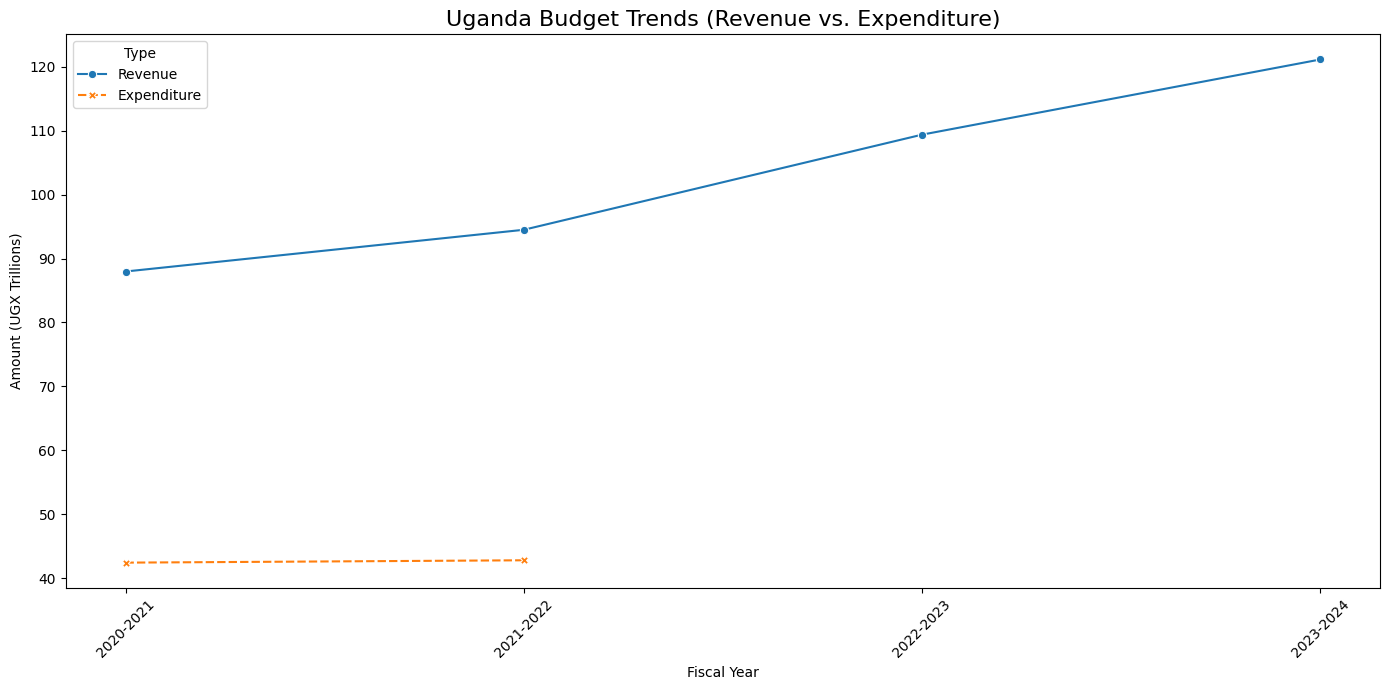

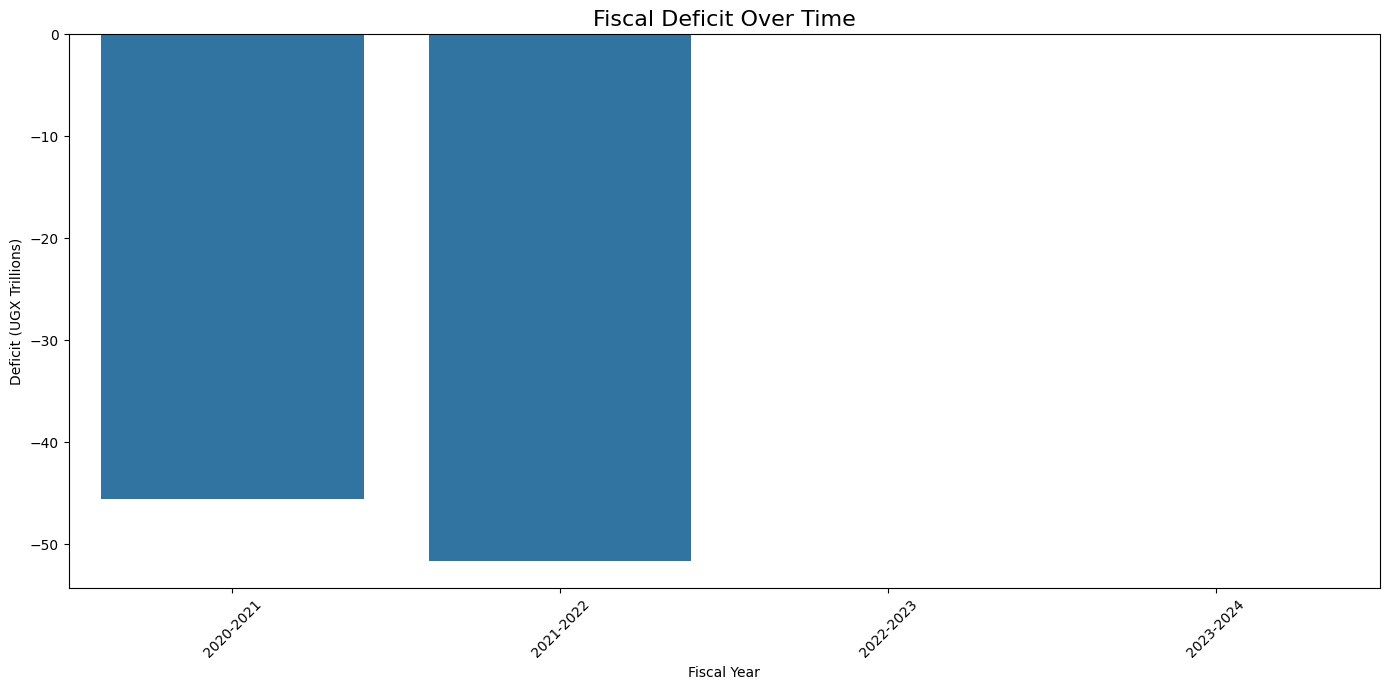

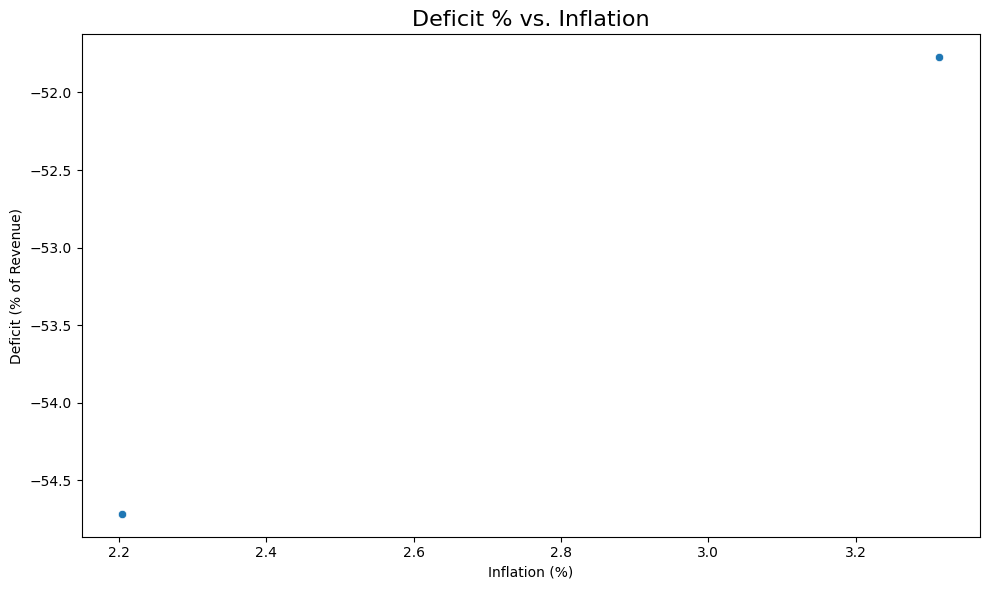

22:55:52 - cmdstanpy - INFO - Chain [1] start processing



Revenue Anomalies: Series([], Name: Revenue, dtype: float64)
Expenditure Anomalies: Series([], Name: Expenditure, dtype: float64)


22:55:52 - cmdstanpy - INFO - Chain [1] done processing
22:55:52 - cmdstanpy - INFO - Chain [1] start processing
22:55:52 - cmdstanpy - INFO - Chain [1] done processing



Key Budget Indicators:
                        Formatted
Latest Year             2023-2024
Revenue (T)           UGX 121.15T
Expenditure (T)          UGX nanT
Deficit (T)              UGX nanT
Deficit % of Revenue         nan%
Revenue Growth %           10.75%
Expenditure Growth %         nan%
Deficit Change %             nan%

Forecast Accuracy - Revenue MAE: 0.00T, Expenditure MAE: 0.00T

Budget Forecast:
Type       Expenditure     Revenue     Deficit
Year                                          
2020-2021    42.427623   87.974200  -45.546577
2021-2022    42.794937   94.502115  -51.707178
2022-2023    15.497718  109.385899  -93.888181
2023-2024   -11.803967  121.146315 -132.950282
2024-2025   -39.094228  130.017542 -169.111770
2025-2026          NaN  136.306073         NaN
2026-2027          NaN  150.951128         NaN

Narrative saved to budget_narrative.txt

Dashboard saved to uganda_budget_dashboard.html


In [9]:
if __name__ == "__main__":
    try:
        # Load and integrate data
        budget, pivot_budget, rev, exp = integrate_budget_data(
            r"C:\Users\okell\OneDrive\Desktop\DVE\Revenue_Data.xlsx",
            r"C:\Users\okell\OneDrive\Desktop\DVE\Expense_Data.xlsx"
        )
        
        # Perform EDA
        plot_eda(budget, pivot_budget, rev, exp)
        rev_anomalies = detect_anomalies(pivot_budget, 'Revenue')
        exp_anomalies = detect_anomalies(pivot_budget, 'Expenditure')
        
        # Calculate KPIs and composition
        kpis = calculate_kpis(pivot_budget)
        rev_comp, exp_comp = analyze_composition(rev, exp, budget['Year'].cat.categories[-1])
        
        # Forecast budget
        forecast, mae_rev, mae_exp = forecast_budget(pivot_budget)
        
        # Generate narrative
        narrative = generate_narrative(pivot_budget, kpis, forecast, rev_anomalies, exp_anomalies)
        with open("budget_narrative.txt", "w") as f:
            f.write(narrative)
        
        # Create and save dashboard
        dashboard = create_interactive_dashboard(budget, pivot_budget, rev_comp, exp_comp, forecast)
        dashboard.write_html("uganda_budget_dashboard.html")
        
        # Display results
        print("\nKey Budget Indicators:")
        print(kpis[['Formatted']].to_string())
        print(f"\nForecast Accuracy - Revenue MAE: {mae_rev:.2f}T, Expenditure MAE: {mae_exp:.2f}T")
        print("\nBudget Forecast:")
        print(forecast.to_string())
        print("\nNarrative saved to budget_narrative.txt")
        print("\nDashboard saved to uganda_budget_dashboard.html")
        
        # Save outputs
        budget.to_csv('clean_budget_data.csv', index=False)
        rev_comp.to_csv('revenue_composition.csv', index=False)
        exp_comp.to_csv('expenditure_composition.csv', index=False)
        forecast.to_csv('budget_forecast.csv', index=False)
        
        try:
            webbrowser.open("uganda_budget_dashboard.html")
        except:
            print("Dashboard saved to:", os.path.abspath("uganda_budget_dashboard.html"))
        
    except Exception as e:
        print(f"Error occurred: {str(e)}")